# SingleR

Single-cell recognition (SingleR) is a tool to automatically annotate a test sample by a reference sample. The core step of SingleR is the calcualation of local spearman coefficients between query sample and the reference (transcriptomic datasets of pure cell types), in order to find the most similar label through continuous fine-tuning [Aran19]. So that it could infer the origin of each cell independently. 

<div class="alert alert-info">

**Note**

When perform SingleR for automatic annotation, the time cost of analysis is much dicated by reference volume. Generally speaking, it takes a relatively long computational time to fulfill the analysis.

Currently, the function supports two methods: `cpu` and `gpu`, default to `cpu`. If clustering is done or there is a `cluster_res_key` as input, `cpu` could fullfill the calculating fast. With clustering information, `gpu` is strongly recommended for remarkable reduction of time consumption.

In addition, you can set `fine_tune_times` and `n_jobs` to get acceleration. `fine_tune_times` is default to 0, which means that calculating will fine-tune until the results decreasing to only 1. So that you could reduce the number of calculation cycles to speed up the calculating. Data may be trotted out and the results will be basically the same. If the data volume is large, the difference between different cycle numbers may be larger.

</div>

<div class="alert alert-warning">

**Important**

If want to run `cusingler`, NVIDIA GPU and cuda-toolkit 11.4 are both necessary.

Install necessary packages by running commands as below:

> &ensp;&ensp; **pip install cusingler**  

</div>

## Annotation with cell labels

We have uploaded three references, `BlueprintEncodeData.Rdata`, `MouseRNAseqData.Rdata` and `Mouse_brain_ref.anndata075.h5ad`, click [our data](http://116.6.21.110:8090/share/c5d9e7f3-7d66-4154-87e1-a740f4bb4dbc) for more details.

The first two are [human](https://rdrr.io/github/LTLA/celldex/man/BlueprintEncodeData.html) and [mouse](https://rdrr.io/github/LTLA/CellTypeReferences/man/MouseRNAseqData.html) references from R package release, apparently by the file suffix. Click [complete information](https://bioconductor.org/packages/release/data/experiment/vignettes/celldex/inst/doc/userguide.html#3_Immune_references), to get all SingleR references in R package.

The third is a downsampling result of [raw big data](http://mousebrain.org/adolescent/downloads.html) with the volume of about 19GB.

Transform `.rda` to `.h5ad` by [rda2h5ad.R](https://github.com/STOmics/Stereopy/blob/dev/docs/source/_static/rda2h5ad.R) :

`Rscript rda2h5ad.R --infile MouseRNAseqData.Rdata --outfile MouseRNAseqData.h5ad`

In [1]:
import stereo as st
import warnings
warnings.filterwarnings('ignore')

test_file = '../data/SS200000135TL_D1.cellbin.gef'
ref_file = '../data/Mouse_brain_ref.anndata075.h5ad'

data = st.io.read_gef(test_file, bin_type='cell_bins')
ref = st.io.read_h5ad(ref_file)

[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1090][INFO]: read_gef begin ...
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1334][INFO]: This is GEF file which contains cell bin infomation.
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1335][INFO]: bin_type: cell_bins
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1341][INFO]: Number of cells: 57133
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1344][INFO]: Number of gene: 24670
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1347][INFO]: Resolution: 500
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1350][INFO]: offsetX: 0
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1353][INFO]: offsetY: 0
[2024-03-28 13:53:37][Stereo][5186][MainThread][140604473845568][reader][1356][INFO]: Average number of genes: 223.460693359375
[2024-03-

version is 0.7.14 
version is 0.7.14 


Get the expression matrix of reference data:

In [2]:
ref

AnnData object with n_obs × n_vars = 67419 × 20170
    obs: 'ClusterName'
    var: 'Accession'
    uns: 'sn'

It is obvious that both reference and test data are raw counts. In order to fulfill a better SingleR analysis, we need to perform normalization of `log1p` and `normalize_total` beforehand.

In [3]:
# preprocessing
ref.tl.normalize_total()
ref.tl.log1p()

data.tl.cal_qc()
data.tl.normalize_total()
data.tl.log1p()

[2024-03-28 13:53:38][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run log1p...
[2024-03-28 13:53:38][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: log1p end, consume time 0.3899s.
[2024-03-28 13:53:38][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run normalize_total...
[2024-03-28 13:53:39][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: normalize_total end, consume time 0.6591s.
[2024-03-28 13:53:39][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run cal_qc...
[2024-03-28 13:53:39][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: cal_qc end, consume time 0.1989s.
[2024-03-28 13:53:39][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run log1p...
[2024-03-28 13:53:39][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: log1p end, consume time 0.0686s.
[2024-03-28 13:53:39][Stereo][5186][MainThread

<div class="alert alert-warning">

**Important**

If you want to use GPU acceleration, the pandas version must be 1.5.3, otherwise an error will be reported during operation, so please do not modify the pandas version at will.



</div>

`ref_use_col='ClusterName'` specifies an obs column used for annotating, here is just an example, the actual value depends on the reference to be used.

In [4]:
# gpu
data.tl.single_r(
    ref_exp_data=ref, 
    ref_use_col='ClusterName', 
    res_key='annotation',
    method='rapids'  #  Specifying the method as rapids means using gpu
)

[2024-03-28 13:53:39][Stereo][5186][MainThread][140604473845568][st_pipeline][77][INFO]: register algorithm single_r to <stereo.core.st_pipeline.StPipeline object at 0x7fe0f47d3940>
INFO:numba.core.transforms:finding looplift candidates
INFO:numba.cuda.cudadrv.driver:init


Same genes in same order, genes size: 19973
train data cost time(s): 5
ref data shape: 67419 x 2213 non-zero number: 101137290
qry data shape: 57133 x 2213 non-zero number: 12482958
free GPU device mem(MB): 23190 total need mem(MB): 1577
Load total ref and qry data into GPU device memory
score() used gpu mem(MB): 2484
score data cost time(s): 258
ref data shape: 67419 x 3335 non-zero number: 101137290
qry data shape: 57133 x 3335 non-zero number: 12482958
free GPU device mem(MB): 23354 total need mem(MB): 1715
Load total ref and qry data into GPU device memory
finetune() used gpu mem(MB): 2458
finetune cost time(s): 6467


[2024-03-28 15:46:21][Stereo][5186][MainThread][140604473845568][single_r][200][INFO]: single-r finished, cost 6761.317797660828 seconds


,bins,group,first_labels
31679678781665,31679678781665,TEGLU3,TEGLU10
31696858650867,31696858650867,VLMC2,VLMC2
31546534795506,31546534795506,ACTE1,ACTE1
31804232833272,31804232833272,VLMC2,VLMC2
32779190409382,32779190409382,ACTE1,OPC
...,...,...,...
33105607937026,33105607937026,VLMC2,VLMC2
33208687152235,33208687152235,ACNT1,ACNT1
32993938787532,32993938787532,ACTE1,ABC
32534377286979,32534377286979,VLMC2,ABC


Display the annotating result bases on just cells.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

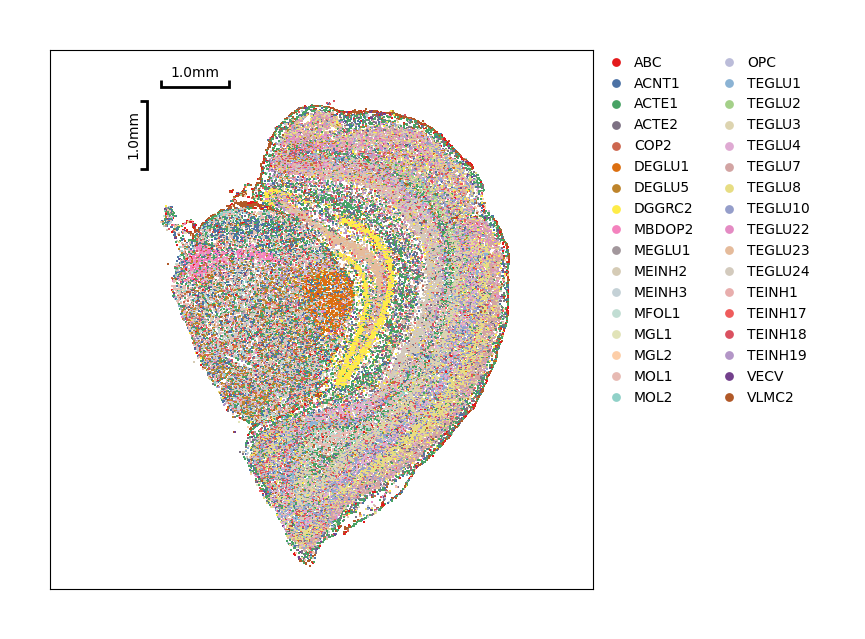

In [5]:
data.plt.cluster_scatter(res_key='annotation')

## Annotation after clustering

We provide the parameter `cluster_res_key` that SingleR will run in cluster mode. For example below, it will tag `leiden` with `ClusterName`.

In [6]:
# embedding and clustering
data.tl.pca(use_highly_genes=False, hvg_res_key='highly_variable_genes', n_pcs=20, res_key='pca', svd_solver='arpack')
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors', n_jobs=8)

data.tl.leiden(neighbors_res_key='neighbors', res_key='leiden')

[2024-03-28 15:46:25][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run pca...
[2024-03-28 15:46:32][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: pca end, consume time 7.2157s.
[2024-03-28 15:46:32][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run neighbors...
[2024-03-28 15:46:49][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: neighbors end, consume time 16.5563s.
[2024-03-28 15:46:49][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run leiden...
[2024-03-28 15:47:52][Stereo][5186][MainThread][140604473845568][pipeline_utils][27][INFO]: Can not find raw data, the data which may have been normalized will be used.
[2024-03-28 15:47:53][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: leiden end, consume time 63.7051s.


Then run with `ref_use_col` whose value is `ClusterName` from reference, and `leiden` result as `cluster_res_key`.

`ref_use_col='ClusterName'` is just an example, the actual value is determined based on the reference you use.

In [7]:
data.tl.single_r(
    ref_exp_data=ref, 
    ref_use_col='ClusterName', 
    cluster_res_key='leiden', 
    res_key='annotation'
)

[2024-03-28 15:47:59][Stereo][5186][MainThread][140604473845568][single_r][153][INFO]: start single-r with n_jobs=40 fine_tune_times=0
[2024-03-28 15:47:59][Stereo][5186][MainThread][140604473845568][single_r][155][INFO]: start training ref...
[2024-03-28 15:48:25][Stereo][5186][MainThread][140604473845568][single_r][158][INFO]: training ref finished, cost 25.801949739456177 seconds
[2024-03-28 15:48:29][Stereo][5186][MainThread][140604473845568][single_r][184][INFO]: start scoring test_data...
100%|██████████| 34/34 [00:00<00:00, 19917.09it/s]
INFO:numba.core.transforms:finding looplift candidates
[2024-03-28 15:48:32][Stereo][5186][MainThread][140604473845568][single_r][187][INFO]: scoring test_data finished, cost 3.1273744106292725 seconds
[2024-03-28 15:48:32][Stereo][5186][MainThread][140604473845568][single_r][189][INFO]: start fine-tuning...
[2024-03-28 15:48:34][Stereo][5186][MainThread][140604473845568][single_r][295][INFO]: fine-tuning with test_data(shape=(14, 19973))
14it [

,bins,group,first_labels
bins,,,
31679678781665,31679678781665,TEGLU4,TEGLU10
31696858650867,31696858650867,VLMC2,ABC
31546534795506,31546534795506,VLMC2,ABC
31804232833272,31804232833272,TEGLU7,TEGLU10
32779190409382,32779190409382,VLMC2,ABC
...,...,...,...
33105607937026,33105607937026,VLMC2,ABC
33208687152235,33208687152235,TEGLU23,TEGLU10
32993938787532,32993938787532,VLMC2,ABC


Display the annotating result bases on clustering.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

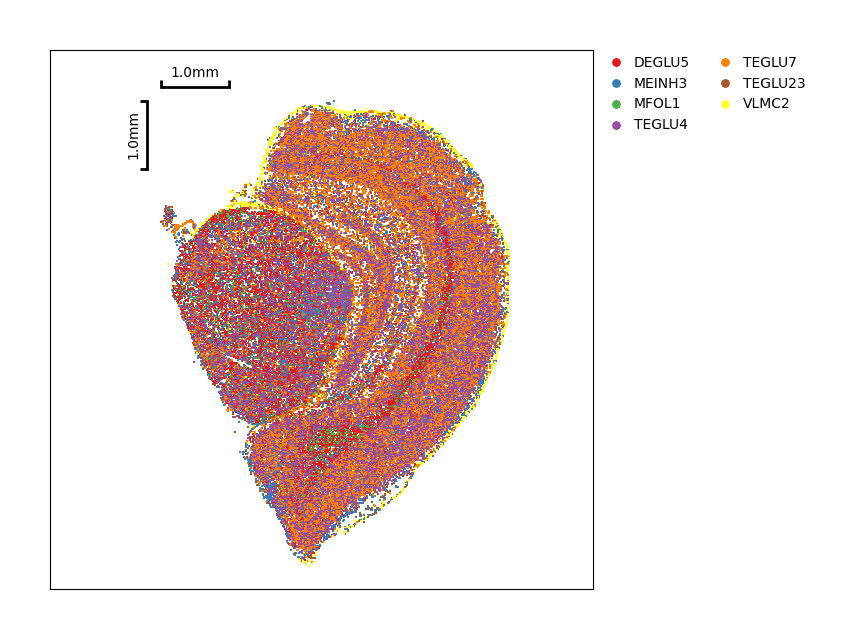

In [8]:
data.plt.cluster_scatter(res_key='annotation')

## Performance

Set `fine_tune_times=1`, which means the result has been fine-tuned only once. This will make the process faster but less accurate.

In [9]:
# read data
test_file = '../data/SS200000135TL_D1.tissue.gef'
ref_file = '../data/MouseRNAseqData.h5ad'

test = st.io.read_gef(test_file, bin_size=100)
ref = st.io.read_h5ad(ref_file)

# preprocessing
test.tl.cal_qc()
test.tl.normalize_total(target_sum=1e4)
test.tl.log1p()

[2024-03-28 15:49:21][Stereo][5186][MainThread][140604473845568][reader][1090][INFO]: read_gef begin ...


path:../data/SS200000135TL_D1.tissue.gef bin:100
               generateBinInfo - 19.800000 cpu sec


[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][reader][1268][INFO]: the matrix has 9124 cells, and 24302 genes.
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][reader][1269][INFO]: read_gef end.
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run cal_qc...
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: cal_qc end, consume time 0.3196s.
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run normalize_total...
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: normalize_total end, consume time 0.1880s.
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][41][INFO]: start to run log1p...
[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][44][INFO]: log1p end, consume time 0.0667s.


In [10]:
test.tl.single_r(
    ref_exp_data=ref, 
    ref_use_col='label.main', 
    res_key='annotation', 
    fine_tune_times=1,
    n_jobs=40
)

[2024-03-28 15:49:34][Stereo][5186][MainThread][140604473845568][st_pipeline][77][INFO]: register algorithm single_r to <stereo.core.st_pipeline.StPipeline object at 0x7fdfe9714490>
[2024-03-28 15:49:37][Stereo][5186][MainThread][140604473845568][single_r][153][INFO]: start single-r with n_jobs=40 fine_tune_times=1
[2024-03-28 15:49:37][Stereo][5186][MainThread][140604473845568][single_r][155][INFO]: start training ref...
[2024-03-28 15:49:41][Stereo][5186][MainThread][140604473845568][single_r][158][INFO]: training ref finished, cost 3.4769856929779053 seconds
[2024-03-28 15:49:41][Stereo][5186][MainThread][140604473845568][single_r][184][INFO]: start scoring test_data...
100%|██████████| 18/18 [00:00<00:00, 33855.37it/s]
[2024-03-28 15:49:44][Stereo][5186][MainThread][140604473845568][single_r][187][INFO]: scoring test_data finished, cost 2.730195999145508 seconds
[2024-03-28 15:49:44][Stereo][5186][MainThread][140604473845568][single_r][189][INFO]: start fine-tuning...
[2024-03-28 1

,bins,group,first_labels
13743895356600,13743895356600,Astrocytes,Epithelial cells
13743895356700,13743895356700,Neurons,Oligodendrocytes
13743895356800,13743895356800,Neurons,Neurons
13743895356900,13743895356900,Neurons,Neurons
13743895357000,13743895357000,Neurons,Neurons
...,...,...,...
57552561777200,57552561777200,Astrocytes,Astrocytes
57552561777300,57552561777300,Neurons,Neurons
57552561777400,57552561777400,Astrocytes,Neurons
57552561777700,57552561777700,Astrocytes,Neurons


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

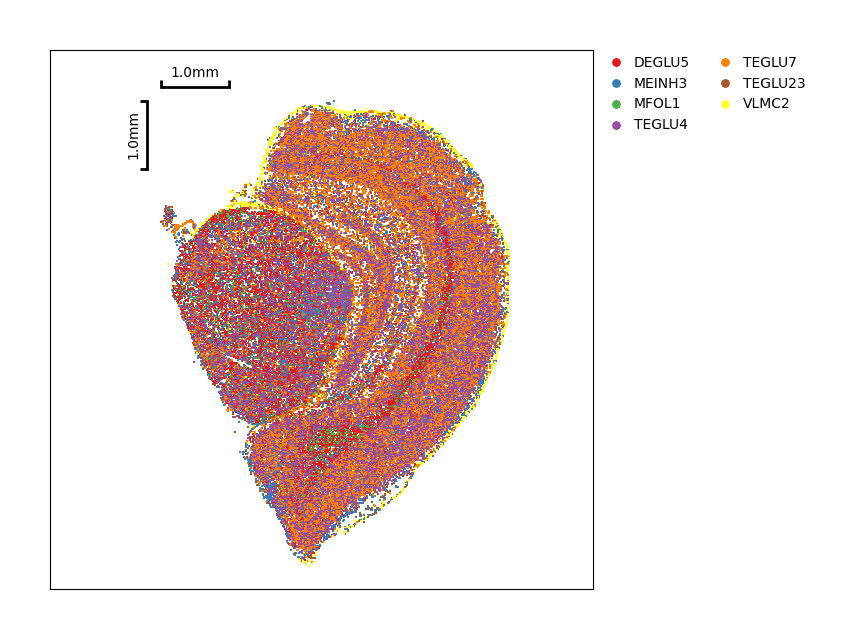

In [11]:
data.plt.cluster_scatter(res_key='annotation')

In [12]:
test.tl.single_r(
    ref_exp_data=ref,
    ref_use_col='label.main', 
    res_key='annotation',
    fine_tune_times=10,
    n_jobs=40
)

[2024-03-28 15:56:14][Stereo][5186][MainThread][140604473845568][single_r][153][INFO]: start single-r with n_jobs=40 fine_tune_times=10
[2024-03-28 15:56:14][Stereo][5186][MainThread][140604473845568][single_r][155][INFO]: start training ref...
[2024-03-28 15:56:20][Stereo][5186][MainThread][140604473845568][single_r][158][INFO]: training ref finished, cost 5.6476099491119385 seconds
[2024-03-28 15:56:20][Stereo][5186][MainThread][140604473845568][single_r][184][INFO]: start scoring test_data...
100%|██████████| 18/18 [00:00<00:00, 19463.13it/s]
[2024-03-28 15:56:23][Stereo][5186][MainThread][140604473845568][single_r][187][INFO]: scoring test_data finished, cost 3.302593946456909 seconds
[2024-03-28 15:56:23][Stereo][5186][MainThread][140604473845568][single_r][189][INFO]: start fine-tuning...
[2024-03-28 15:56:23][Stereo][5186][MainThread][140604473845568][single_r][295][INFO]: fine-tuning with test_data(shape=(9124, 16433))
80it [00:00, 579.34it/s]INFO:numba.core.transforms:finding 

,bins,group,first_labels
13743895356600,13743895356600,Epithelial cells,Epithelial cells
13743895356700,13743895356700,Oligodendrocytes,Oligodendrocytes
13743895356800,13743895356800,Neurons,Neurons
13743895356900,13743895356900,Neurons,Neurons
13743895357000,13743895357000,Neurons,Neurons
...,...,...,...
57552561777200,57552561777200,Neurons,Astrocytes
57552561777300,57552561777300,Neurons,Neurons
57552561777400,57552561777400,Neurons,Neurons
57552561777700,57552561777700,Neurons,Neurons


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

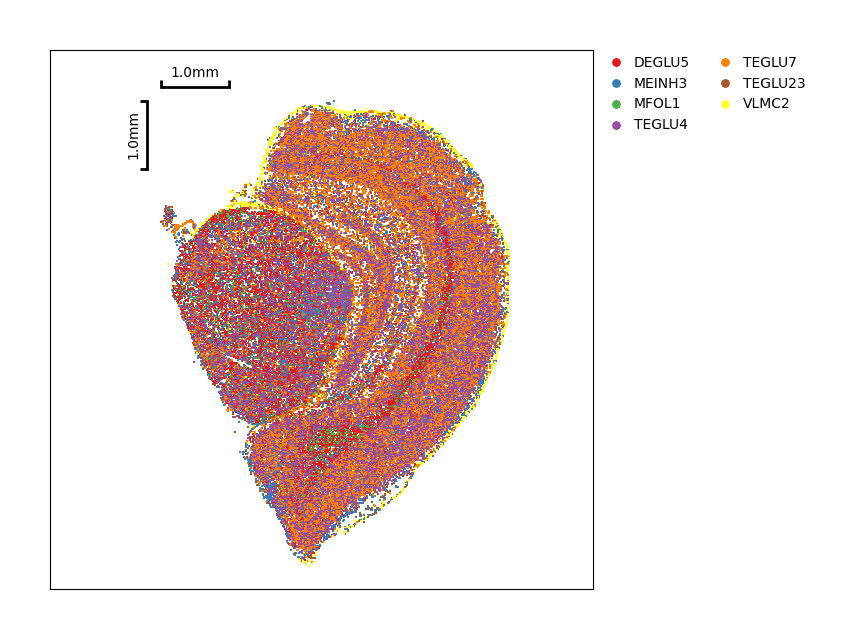

In [13]:
data.plt.cluster_scatter(res_key='annotation')

In [14]:
test.tl.single_r(
    ref_exp_data=ref,
    ref_use_col='label.main', 
    res_key='annotation',
    method='rapids'
)

[2024-03-28 16:05:46][Stereo][5186][MainThread][140604473845568][single_r][200][INFO]: single-r finished, cost 54.125330209732056 seconds


Same genes in same order, genes size: 16433
train data cost time(s): 1
ref data shape: 358 x 3226 non-zero number: 5883014
qry data shape: 9124 x 3226 non-zero number: 25284828
free GPU device mem(MB): 23701 total need mem(MB): 175
Load total ref and qry data into GPU device memory
score() used gpu mem(MB): 571
score data cost time(s): 10
ref data shape: 358 x 7457 non-zero number: 5883014
qry data shape: 9124 x 7457 non-zero number: 25284828
free GPU device mem(MB): 23647 total need mem(MB): 20
Load total ref and qry data into GPU device memory
finetune() used gpu mem(MB): 470
finetune cost time(s): 21


,bins,group,first_labels
13743895356600,13743895356600,Epithelial cells,Epithelial cells
13743895356700,13743895356700,Oligodendrocytes,Oligodendrocytes
13743895356800,13743895356800,Neurons,Neurons
13743895356900,13743895356900,Neurons,Neurons
13743895357000,13743895357000,Neurons,Neurons
...,...,...,...
57552561777200,57552561777200,Neurons,Astrocytes
57552561777300,57552561777300,Neurons,Neurons
57552561777400,57552561777400,Neurons,Neurons
57552561777700,57552561777700,Neurons,Neurons


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

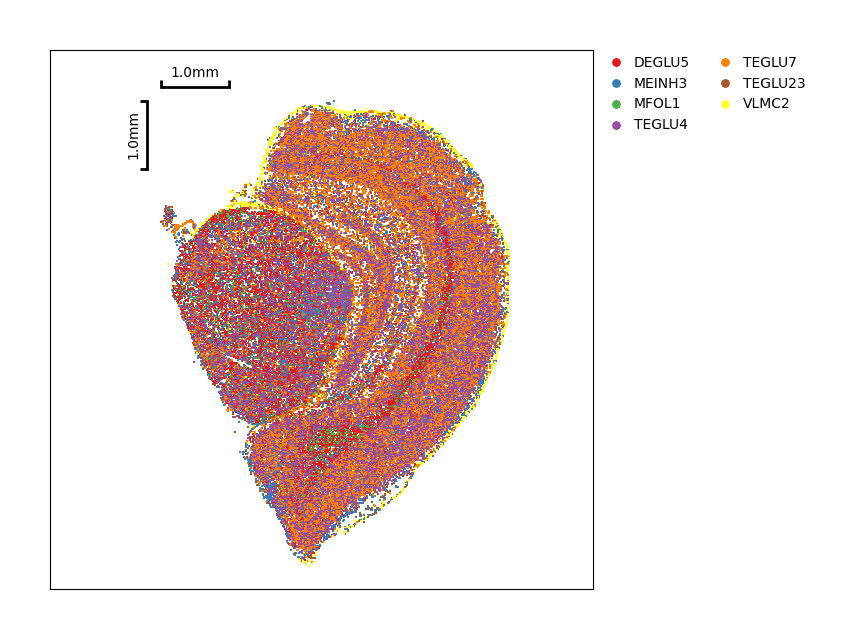

In [15]:
data.plt.cluster_scatter(res_key='annotation')